In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

%load_ext autoreload
%autoreload 2

# Autoregressive Models

Concise lecture notes from PSU https://online.stat.psu.edu/stat501/lesson/14/14.2

A $p$-order AR model, denoted AR($p$), is one where a measurement $y_t$ at time $t$ depends linearly on its $p$ previous time steps plus some error $\epsilon_t \sim_{i.i.d.} \mathcal{N}(0, \sigma^2)$, i.e.
$$
y_t = a_0 + a_1 y_{t-1} + a_2 y_{t-2} + \dots + a_k y_{t-k} + \epsilon_t
$$

To avoid blowup of the sequence, you generally want to enforce that the weight matrix has spectral radius at most 1.

In [2]:
def generate_ar_sequence(n_samples, order=1, err_variance=1, washout=100):
    eps = np.random.normal(0, np.sqrt(err_variance), n_samples + washout)
    a0 = np.random.random()
    a = np.random.random(order)
    y = np.zeros(n_samples + washout)
    for t in range(order, n_samples + washout):
        y[t] = a0 + a.T.dot(y[t-order:t]) + eps[t]
    return y[washout:]

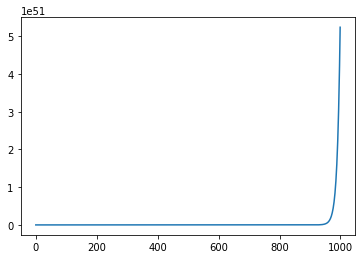

In [3]:
T = 1000
t = np.arange(T)
y = generate_ar_sequence(T, order=2)

sns.lineplot(t, y);

array([ 0.53890418, -0.30428064,  0.45599793,  0.88555644,  0.72773385,
        0.38604072])

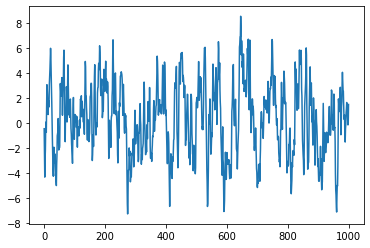

In [4]:
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA

T = 1000
t = np.arange(T)

arparams = np.array([.75, -.25, 0.3])
maparams = np.array([.65, .35, 0.2])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

y = arma_generate_sample(ar, ma, T)

sns.lineplot(t, y);

model = ARMA(y, (3, 3)).fit(trend='nc', disp=0)
model.params

# Vector Autoregressive Model

Suppose you take $k$ endogenous measurements $y_t \in \mathbb{R}^k$ at each time step $t$. Let $u_t$ be some exogenous measurement that also contributes some predictive value to $y_t$. We can construct a vector AR($p$) (VAR) model following the equation:
$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + b u_t + \epsilon_t
$$
where each $a_i \in \mathbb{R}^{k \times k}$, $b \in \mathbb{R}^{k \times k}$, and $\epsilon_t \in \mathbb{R}^{k \times k}$. We can represent this with matrix notation as

$$
Y_t = AY_{t-1:t-p} + bu_t + \epsilon_t
$$
where $A \in \mathbb{R}^{p \times k \times k}$ and $Y_{t-1:t-p}$ is a matrix of concatenated $k$-element columns for each time step from $t-1$ down to $t-p$.

In [5]:
from statsmodels.tsa.vector_ar.var_model import VARProcess

T = 1000
t = np.arange(T)

# coefs are the weights on lag variables
coefs = np.array([[[0.1, 0.2, 0.3],
                   [0.3, -0.8, -0.15],
                   [0.4, 0.2, -0.6]]])

# coefs_exogs are weights on exogenous variables (not lag)
# coefs_exog = np.array([[0.5, -0.7, 0.3],
#                        [0.32, -0.2, 0.62],
#                        [0.18, -0.42, 0.5]])
coefs_exog = np.zeros((3, 3))

# sigma_u are covariances of error terms
sigma_u = np.array([[0.6, -0.2, 0.3],
                    [-0.2, 0.7, 0.15],
                    [0.3, 0.15, 0.73]])
var = VARProcess(coefs, coefs_exog, sigma_u, _params_info={'k_trend': 0})

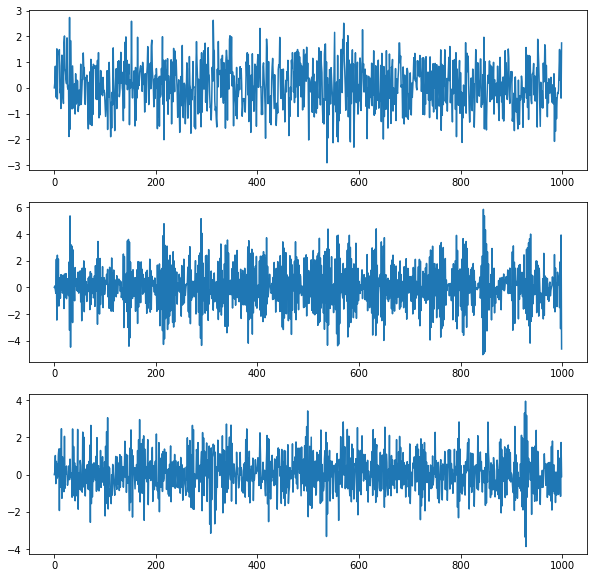

In [6]:
var.plotsim();

In [7]:
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier

In [83]:
from statsmodels.tsa.vector_ar.var_model import VARProcess

def generate_ar_samples(cls=0, n_steps=1000, k=1):
    """
    Generate multivariate time-series for 3 channsl of length n_samples
    from a vector AR(1) model. Noise channels are interleaved between
    the vector sequences.

    VAR(1) Model: 
    y(t+1) = Ay(t) + Bu(t) + err(t)

    For now, we ignore exogenous variables, i.e. B = 0, and assume
    uncorrelated errors.
    """

    n_chs = 3
    n_noise_chs = 3

    if cls == 0:
        A = np.array([[
            [  0.5,  0.5*k, 0.7*k],
            [0.3*k, -0.8, -0.15*k],
            [0.5*k,  0.2*k, -0.6]
        ]])
    elif cls == 1:
        A = np.array([[
            [0.5,    0,    0],
            [  0, -0.8,    0],
            [  0,    0, -0.6]
        ]])

    B = np.zeros((n_chs, n_chs))

    A_eigvals = np.linalg.eigvals(A)
    A_spec_rad = np.max(np.abs(A_eigvals))

    # TODO: Figure out how to best set error relative to A matrix
    err_cov = 0.05 * A_spec_rad * np.identity(n_chs)

    var = VARProcess(A, B, err_cov, _params_info={'k_trend': 0})
    y = var.simulate_var(steps=n_steps).T
    assert y.shape == (n_chs, n_steps)

    y_noise = np.random.random((n_noise_chs, n_steps))

    y = np.vstack((
        y[0,:], y_noise[0,:],
        y[1,:], y_noise[1,:],
        y[2,:], y_noise[2,:]
    ))
    
    return y

In [84]:
T = 1000
ns = np.array([50,100,200,400,1000,2000])
nchs = 6
test_size = 0.5
seed = 1234

# initialize data structures for train/test data
X_train, Y_train = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))
X_test, Y_test = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))

for n in ns:
    X, y = [], []

    # generate correlated multi-variate time series
    for i in range(n):
        _x = generate_ar_samples(cls=0, n_steps=T)
        X.append(_x)
        y.append(0)
    for i in range(n):
        _x = generate_ar_samples(cls=1, n_steps=T)
        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)

    # perform training test split
    _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=seed)
    X_train = np.vstack((X_train, _X_train))
    Y_train = np.hstack((Y_train, _y_train))
    X_test = np.vstack((X_test, _X_test))
    Y_test = np.hstack((Y_test, _y_test))

print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape, Y_train.shape, X_test.shape)

(3750, 6, 1000)
(3750, 6000) (3750,) (3750, 6000)


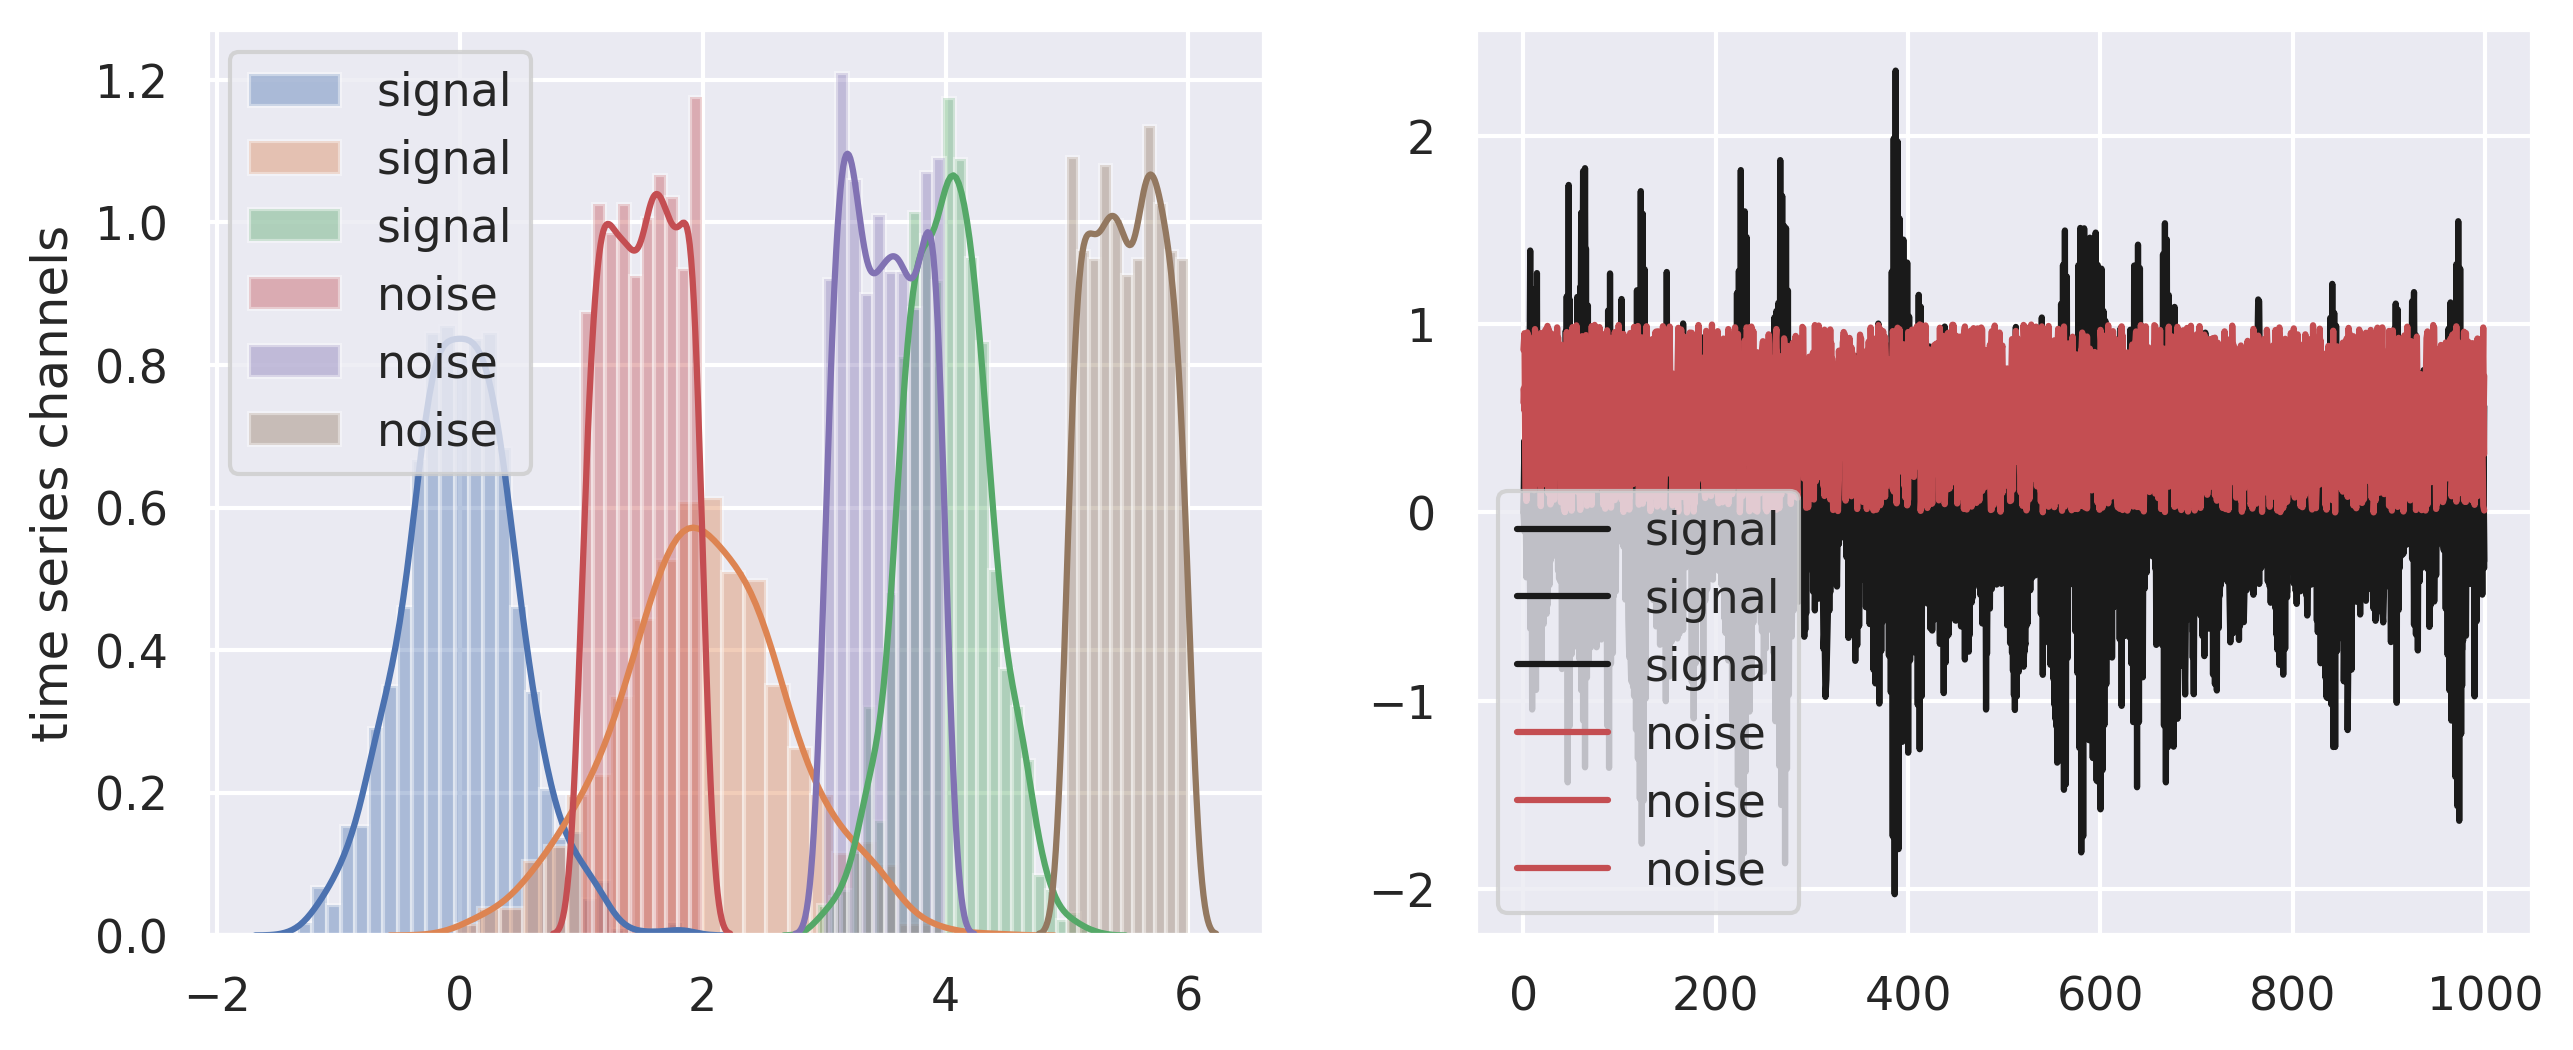

In [85]:
# Plot various projections of the samples.
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax = axs[0]
#for i in range(6):
#    sns.distplot(X_train[0, i*T:T*(i+1)]+np.r_[i], ax=ax)
for i in [0, 2, 4]:
    sns.distplot(X_train[0, i*T:T*(i+1)]+np.r_[i], ax=ax, label='signal')
for i in [1, 3, 5]:
    sns.distplot(X_train[0, i*T:T*(i+1)]+np.r_[i], ax=ax, label='noise')
ax.set_ylabel('time series channels')
ax.legend()
# plt.axis('equal')
plt.grid(True)

ax = axs[1]
for i in [0, 2, 4]:
    ax.plot(X_train[0, i*T:T*(i+1)], 'k', label='signal')
for i in [1, 3, 5]:
    ax.plot(X_train[0, i*T:T*(i+1)], 'r', label='noise')
ax.legend()
plt.show()

In [86]:
## Setup for run
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red", "MT-MORF": "orange"}

ncores=1
num_runs=1
n_est=100  # number of estimators

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=nchs,
                    image_width=T,
                    patch_height_max=3,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=5
                   ),
    rerfClassifier(projection_matrix="MT-MORF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=nchs,
                    image_width=T,
                    patch_height_max=3,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=5
                   )
    ]

# Run Classification Comparison Experiment

Perform a classification over all models, and then summarize in a figure

In [87]:
runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]
print("About to run", len(runList), "clf experiments")
print(n)
print(ns)
print(len(classifiers))
print(num_runs)

About to run 48 clf experiments
2000
[  50  100  200  400 1000 2000]
8
1


In [88]:
# Train each classifier on each dataset size, then test
# Prep output file:
fname = './mt-morf_impulse_experiment.csv'
f = open(fname, 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

for n, clf, iteration in tqdm(runList):
    # print(clf)
    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[-1]).T
    if X_test.ndim == 3:
        X_test = X_test.reshape(-1, X_test.shape[-1]).T
    X = X_train[:n]
    y = Y_train[:n]

    trainStartTime = time.time()
    clf[0].fit(X, y)
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    lhat = np.mean(np.not_equal(out, Y_test).astype(int))


    ####("variable,Lhat,trainTime,testTime,iterate")
    f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
    f.flush()

f.close()

100%|██████████| 48/48 [12:58<00:00, 16.21s/it]


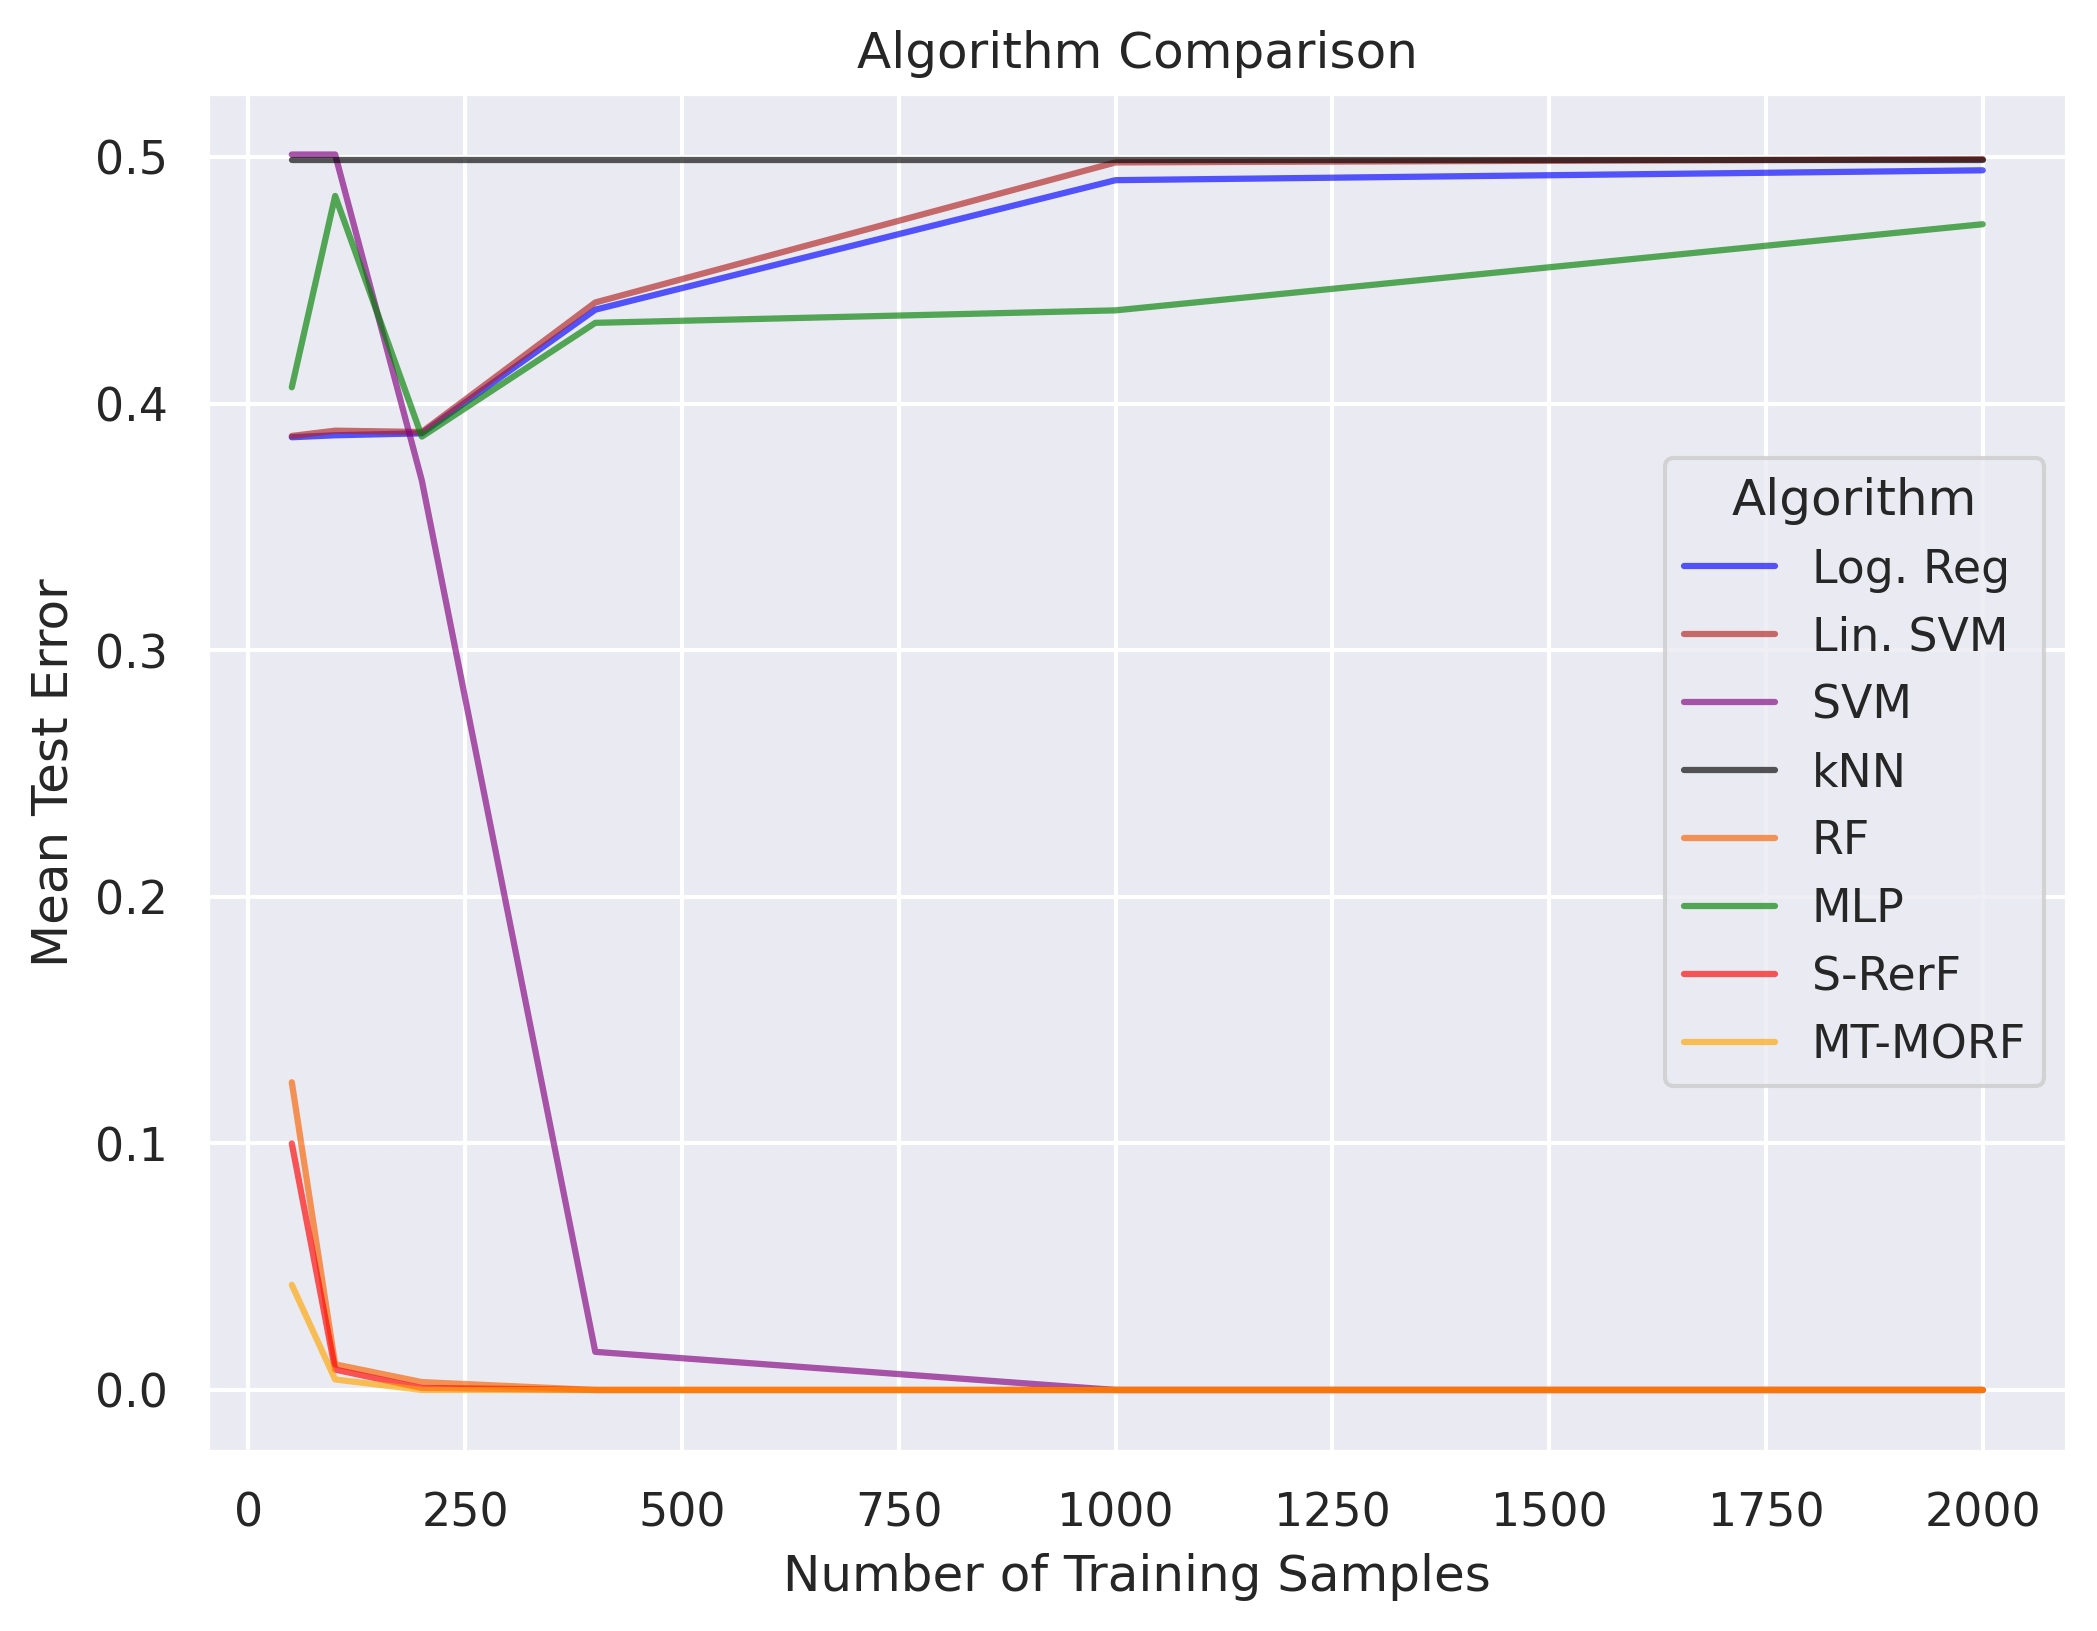

In [89]:
dat = pd.read_csv(fname)

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):
        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='best',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
plt.show()